In [27]:
import os
import sys

# Set project root
PROJECT_ROOT = os.path.abspath("..")
if PROJECT_ROOT not in sys.path:
    sys.path.append(PROJECT_ROOT)

# Results directory
RESULTS_DIR = os.path.join(PROJECT_ROOT, "results")
os.makedirs(RESULTS_DIR, exist_ok=True)

print("Project root:", PROJECT_ROOT)
print("Results dir:", RESULTS_DIR)


Project root: c:\Users\jchen\AppliedAIProjects\mini-project-4
Results dir: c:\Users\jchen\AppliedAIProjects\mini-project-4\results


In [28]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt

from src.model import FashionClassifier
from src.train import train_model
from src.utils import (
    get_predictions,
    plot_confusion_matrix,
    plot_training_curves,
    cost_weighted_accuracy
)


In [29]:
transform = transforms.ToTensor()

train_data = datasets.FashionMNIST(
    root=os.path.join(PROJECT_ROOT, "data"),
    train=True,
    download=True,
    transform=transform
)

test_data = datasets.FashionMNIST(
    root=os.path.join(PROJECT_ROOT, "data"),
    train=False,
    download=True,
    transform=transform
)

train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64)


100%|██████████| 26.4M/26.4M [00:05<00:00, 4.89MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 166kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.09MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 19.2MB/s]


In [30]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


In [31]:
experiments = [
    {
        "name": "Baseline",
        "hidden_sizes": [128],
        "dropout": 0.0,
        "optimizer": "SGD",
        "lr": 0.01
    },
    {
        "name": "Medium",
        "hidden_sizes": [256, 128],
        "dropout": 0.3,
        "optimizer": "Adam",
        "lr": 0.001
    },
    {
        "name": "Deep",
        "hidden_sizes": [512, 256, 128],
        "dropout": 0.4,
        "optimizer": "AdamW",
        "lr": 0.001
    }
]


In [32]:
criterion = nn.CrossEntropyLoss()
experiment_results = []

for exp in experiments:
    print(f"\nRunning experiment: {exp['name']}")

    model = FashionClassifier(
        hidden_sizes=exp["hidden_sizes"],
        dropout=exp["dropout"]
    ).to(device)

    if exp["optimizer"] == "SGD":
        optimizer = torch.optim.SGD(model.parameters(), lr=exp["lr"])
    elif exp["optimizer"] == "Adam":
        optimizer = torch.optim.Adam(model.parameters(), lr=exp["lr"])
    else:
        optimizer = torch.optim.AdamW(model.parameters(), lr=exp["lr"])

    train_losses, val_accuracies = train_model(
        model,
        train_loader,
        test_loader,
        criterion,
        optimizer,
        device,
        epochs=10
    )

    experiment_results.append({
        "name": exp["name"],
        "final_accuracy": val_accuracies[-1],
        "train_losses": train_losses,
        "val_accuracies": val_accuracies,
        "model": model
    })



Running experiment: Baseline
Epoch 1/10 | Loss: 1.1427 | Val Acc: 0.7233
Epoch 2/10 | Loss: 0.6736 | Val Acc: 0.7831
Epoch 3/10 | Loss: 0.5772 | Val Acc: 0.7965
Epoch 4/10 | Loss: 0.5292 | Val Acc: 0.8140
Epoch 5/10 | Loss: 0.5005 | Val Acc: 0.8161
Epoch 6/10 | Loss: 0.4813 | Val Acc: 0.8244
Epoch 7/10 | Loss: 0.4658 | Val Acc: 0.8256
Epoch 8/10 | Loss: 0.4546 | Val Acc: 0.8311
Epoch 9/10 | Loss: 0.4452 | Val Acc: 0.8325
Epoch 10/10 | Loss: 0.4360 | Val Acc: 0.8364

Running experiment: Medium
Epoch 1/10 | Loss: 0.5934 | Val Acc: 0.8410
Epoch 2/10 | Loss: 0.4203 | Val Acc: 0.8403
Epoch 3/10 | Loss: 0.3897 | Val Acc: 0.8658
Epoch 4/10 | Loss: 0.3660 | Val Acc: 0.8640
Epoch 5/10 | Loss: 0.3530 | Val Acc: 0.8661
Epoch 6/10 | Loss: 0.3396 | Val Acc: 0.8744
Epoch 7/10 | Loss: 0.3294 | Val Acc: 0.8761
Epoch 8/10 | Loss: 0.3204 | Val Acc: 0.8786
Epoch 9/10 | Loss: 0.3121 | Val Acc: 0.8829
Epoch 10/10 | Loss: 0.3057 | Val Acc: 0.8805

Running experiment: Deep
Epoch 1/10 | Loss: 0.6456 | Val Ac

In [33]:
for r in experiment_results:
    print(f"{r['name']} final accuracy: {r['final_accuracy']:.4f}")


Baseline final accuracy: 0.8364
Medium final accuracy: 0.8805
Deep final accuracy: 0.8775


In [34]:
best = max(experiment_results, key=lambda x: x["final_accuracy"])

plot_training_curves(
    best["train_losses"],
    best["val_accuracies"],
    os.path.join(RESULTS_DIR, "training_curves.png")
)

In [35]:
y_pred, y_true, confs = get_predictions(
    best["model"], test_loader, device
)

plot_confusion_matrix(
    y_true,
    y_pred,
    os.path.join(RESULTS_DIR, "confusion_matrix.png")
)

In [36]:
cost_matrix = np.ones((10, 10))

cost_matrix[6, 0] = 5  # Shirt → T-shirt
cost_matrix[4, 2] = 5  # Coat → Pullover
cost_matrix[5, 7] = 3  # Sandal → Sneaker
cost_matrix[9, 7] = 3  # Ankle boot → Sneaker

cwa = cost_weighted_accuracy(y_true, y_pred, cost_matrix)
print("Cost-weighted accuracy:", round(cwa, 4))


Cost-weighted accuracy: 0.8856


In [37]:
thresholds = np.linspace(0.5, 0.99, 20)
accuracies = []
coverage = []

for t in thresholds:
    mask = confs >= t
    if mask.sum() == 0:
        accuracies.append(0)
        coverage.append(0)
        continue

    accuracies.append((y_pred[mask] == y_true[mask]).mean())
    coverage.append(mask.mean())

plt.plot(thresholds, accuracies, label="Accuracy")
plt.plot(thresholds, coverage, label="Coverage")
plt.xlabel("Confidence Threshold")
plt.legend()
plt.savefig(os.path.join(RESULTS_DIR, "confidence_threshold.png"))
plt.close()


In [38]:
# Fashion-MNIST labels
class_names = [
    "T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
    "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"
]

# Get predictions (if not already computed)
y_pred, y_true, confs = get_predictions(
    best["model"], test_loader, device
)

# Find misclassified indices
misclassified = np.where(y_pred != y_true)[0]

print(f"Total misclassified samples: {len(misclassified)}")

Total misclassified samples: 1195


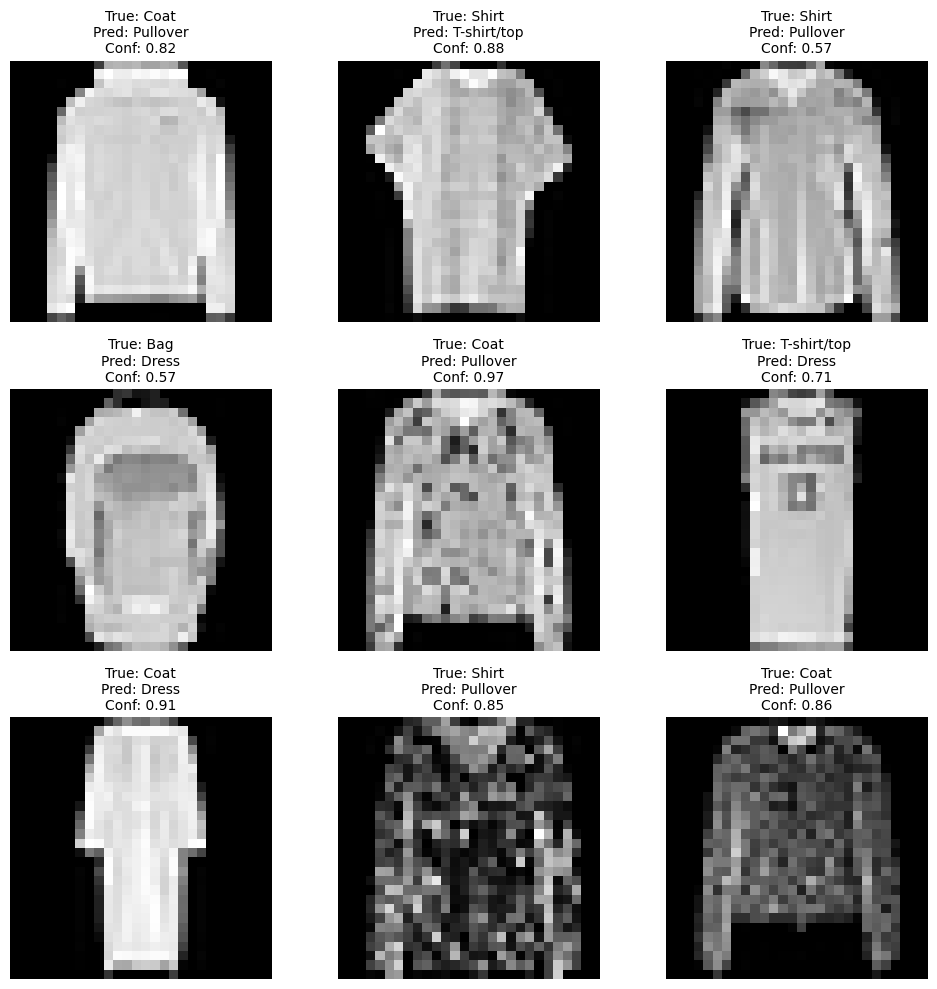

In [39]:
num_images = 9
indices = np.random.choice(misclassified, num_images, replace=False)

plt.figure(figsize=(10, 10))

for i, idx in enumerate(indices):
    image, label = test_data[idx]

    plt.subplot(3, 3, i + 1)
    plt.imshow(image.squeeze(), cmap="gray")
    plt.axis("off")

    true_label = class_names[y_true[idx]]
    pred_label = class_names[y_pred[idx]]
    confidence = confs[idx]

    plt.title(
        f"True: {true_label}\n"
        f"Pred: {pred_label}\n"
        f"Conf: {confidence:.2f}",
        fontsize=10
    )

plt.tight_layout()
plt.savefig(os.path.join(RESULTS_DIR, "misclassified_examples.png"))
plt.show()
